In [2]:
from mofapy2.run.entry_point import entry_point
import pandas as pd
import numpy as np
import os
import scanpy as sc
import mofax as mfx

from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns
import decoupler as dc

# initialise the entry point
ent = entry_point()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.



        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        


In [3]:
# see deconv.py
def lookup(model_call, sample_entry):
    if model_call == "all":
        reg_model = "All"
    elif model_call == "condition":
        if sample_entry["Condition"] == "Control":
            reg_model = "Control"
        elif sample_entry["Condition"] == "MS":
            reg_model = "MS"
        else:
            raise ValueError("Unknown condition")
    elif model_call == "lesion_type":
        if sample_entry["lesion_type"] == "Ctrl":
            reg_model = "Control"
        elif sample_entry["lesion_type"] == "CI":
            reg_model = "CI"
        elif sample_entry["lesion_type"] == "CA":
            reg_model = "CA"
        elif sample_entry["lesion_type"] == "A":
            reg_model = "A"
        else:
            raise ValueError("Unknown lesion type")
    else:
        raise ValueError("Unknown model")
    return reg_model

In [27]:
current_path = globals()["_dh"][0]
out_file = current_path / ".." / ".." / "data" / "prc" / "vis" / "mofa_test.hdf5"
visium_path = current_path / ".." / ".." / "data" / "prc" / "vis" / "processed"
visium_samples = [f.split(".")[0] for f in os.listdir(visium_path) if not f.startswith(".")]
print(np.array(visium_samples))

['MS549H' 'CO85' 'MS371' 'MS197U' 'CO41' 'MS377T' 'MS229' 'CO37' 'MS497I'
 'CO40' 'CO96' 'MS371N' 'MS586' 'MS197D' 'MS94' 'CO74' 'MS377N' 'MS549T'
 'MS411' 'MS466' 'MS377I' 'MS497T']


In [28]:
sample_meta = pd.read_excel(current_path / ".." / ".." / "data" / "Metadata_all.xlsx", sheet_name="Visium")
sample_meta

,patient_id,sample_id,Condition,lesion_type,Age,Sex,RIN,Batch,visium,snRNA-seq
0,MS94 A1D9,MS94,MS,CA,42,F,8.7,1,True,False
1,MS197 P2D3,MS197U,MS,CA,52,F,9.0,1,True,True
2,MS197 P2D3,MS197D,MS,CA,52,F,9.0,1,True,True
3,MS229 P2C2,MS229,MS,CA,53,M,7.0,1,True,True
4,MS371 A3D3,MS371,MS,A,40,M,7.9,1,True,False
5,MS371 A3D6,MS371N,MS,A,40,M,7.6,3,True,True
6,MS377 A2D2,MS377N,MS,CA,50,F,8.9,3,True,True
7,MS377 A2D4,MS377I,MS,CA,50,F,6.5,1,True,True
8,MS377 A2D4,MS377T,MS,CA,50,F,6.5,1,True,True
9,MS411 A2A2,MS411,MS,CA,61,M,5.9,1,True,True


In [67]:
vis_dict = {smp: sc.read_h5ad(visium_path / f"{smp}.h5ad") for smp in visium_samples}

In [68]:
first_sample = visium_samples[0]
print(first_sample)
vis_dict[first_sample]

MS549H


AnnData object with n_obs × n_vars = 3598 × 20205
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'log1p', 'spatial'
    obsm: 'abunds_all', 'abunds_condition', 'abunds_lesion_type', 'hallmark_estimates', 'hallmark_pvals', 'histogram', 'progeny_estimates', 'progeny_pvals', 'props_all', 'props_condition', 'props_lesion_type', 'reactome_estimates', 'reactome_pvals', 'spatial', 'summary', 'texture'
    layers: 'counts'

In [69]:
obsm_to_use = ["abunds_all", "hallmark_estimates"]
#obsm_to_use = ["abunds_all", "hallmark_estimates", "summary"]
assert np.all(np.isin(obsm_to_use, vis_dict[first_sample].obsm_keys()))

In [88]:
obsm_features = {obsm_key: vis_dict[first_sample].obsm[obsm_key].columns.to_list() for obsm_key in obsm_to_use}

In [76]:
meta_list = []
for sample in visium_samples:
    df = vis_dict[sample].obs.copy()
    df.index = [sample + "_" + s for s in df.index]
    df["sample_id"] = sample
    df["condition"] = sample_meta.loc[sample_meta.sample_id == sample, "Condition"].values[0]
    df["lesion_type"] = sample_meta.loc[sample_meta.sample_id == sample, "lesion_type"].values[0]
    meta_list.append(df)
meta_df = pd.concat(meta_list, axis=0)
meta_df

,in_tissue,array_row,array_col,n_genes,sample_id,condition,lesion_type
MS549H_AAACAAGTATCTCCCA-1,1,50,102,6311,MS549H,MS,CI
MS549H_AAACACCAATAACTGC-1,1,59,19,845,MS549H,MS,CI
MS549H_AAACAGAGCGACTCCT-1,1,14,94,1216,MS549H,MS,CI
MS549H_AAACAGCTTTCAGAAG-1,1,43,9,1139,MS549H,MS,CI
MS549H_AAACAGGGTCTATATT-1,1,47,13,1120,MS549H,MS,CI
...,...,...,...,...,...,...,...
MS497T_TTGTTTCACATCCAGG-1,1,58,42,997,MS497T,MS,CI
MS497T_TTGTTTCATTAGTCTA-1,1,60,30,995,MS497T,MS,CI
MS497T_TTGTTTCCATACAACT-1,1,45,27,1056,MS497T,MS,CI
MS497T_TTGTTTGTATTACACG-1,1,73,41,995,MS497T,MS,CI


In [74]:
df_list = []
for obsm_key in obsm_to_use:
    for sample in visium_samples:
        df = vis_dict[sample].obsm[obsm_key].copy()
        df.index = [sample + "_" + s for s in df.index] # unique barcodes are required!
        df = df.reset_index().melt(id_vars="index", var_name="feature", value_name="value")
        df = df.rename(columns={"index": "sample"})
        df["group"] = sample
        df["view"] = obsm_key
        df = df[["sample", "group", "feature", "value", "view"]]
        df_list.append(df)
data_dt = pd.concat(df_list)
data_dt

,sample,group,feature,value,view
0,MS549H_AAACAAGTATCTCCCA-1,MS549H,Astros,0.742379,abunds_all
1,MS549H_AAACACCAATAACTGC-1,MS549H,Astros,0.580995,abunds_all
2,MS549H_AAACAGAGCGACTCCT-1,MS549H,Astros,0.391044,abunds_all
3,MS549H_AAACAGCTTTCAGAAG-1,MS549H,Astros,0.696279,abunds_all
4,MS549H_AAACAGGGTCTATATT-1,MS549H,Astros,0.747300,abunds_all
...,...,...,...,...,...
234845,MS497T_TTGTTTCACATCCAGG-1,MS497T,XENOBIOTIC_METABOLISM,1.492284,hallmark_estimates
234846,MS497T_TTGTTTCATTAGTCTA-1,MS497T,XENOBIOTIC_METABOLISM,1.696120,hallmark_estimates
234847,MS497T_TTGTTTCCATACAACT-1,MS497T,XENOBIOTIC_METABOLISM,2.636975,hallmark_estimates
234848,MS497T_TTGTTTGTATTACACG-1,MS497T,XENOBIOTIC_METABOLISM,1.681285,hallmark_estimates


In [49]:
# scale each view to unit variance?
ent.set_data_options(
    scale_views = True
)

Scaling views to unit variance...



In [50]:
# set the likelihoods
ent.set_data_df(data_dt, likelihoods = ["gaussian", "gaussian"])



Loaded group='CO37' view='abunds_all' with N=4001 samples and D=12 features...
Loaded group='CO37' view='hallmark_estimates' with N=4001 samples and D=50 features...
Loaded group='CO40' view='abunds_all' with N=4000 samples and D=12 features...
Loaded group='CO40' view='hallmark_estimates' with N=4000 samples and D=50 features...
Loaded group='CO41' view='abunds_all' with N=4504 samples and D=12 features...
Loaded group='CO41' view='hallmark_estimates' with N=4504 samples and D=50 features...
Loaded group='CO74' view='abunds_all' with N=3006 samples and D=12 features...
Loaded group='CO74' view='hallmark_estimates' with N=3006 samples and D=50 features...
Loaded group='CO85' view='abunds_all' with N=4449 samples and D=12 features...
Loaded group='CO85' view='hallmark_estimates' with N=4449 samples and D=50 features...
Loaded group='CO96' view='abunds_all' with N=4122 samples and D=12 features...
Loaded group='CO96' view='hallmark_estimates' with N=4122 samples and D=50 features...
Lo

In [51]:
# set the model options
ent.set_model_options(
    factors = 10, 
    spikeslab_weights = True, 
    ard_weights = True
)


Model options:
- Automatic Relevance Determination prior on the factors: False
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True
Likelihoods:
- View 0 (abunds_all): gaussian
- View 1 (hallmark_estimates): gaussian




In [52]:
# set the training options
ent.set_train_options(
    convergence_mode = "fast", 
    dropR2 = 0.001, 
    gpu_mode = True, 
    seed = 1
)


GPU mode is activated, but GPU not found... switching to CPU mode
For GPU mode, you need:
1 - Make sure that you are running MOFA+ on a machine with an NVIDIA GPU
2 - Install CUPY following instructions on https://docs-cupy.chainer.org/en/stable/install.html

Consider training the model with set drop_factor_threshold = -1 and prune them a posteriori


In [53]:
ent.build()

In [54]:
ent.run()



######################################
## Training the model with seed 1 ##
######################################


ELBO before training: -36757357.07 

Iteration 1: time=1.66, ELBO=-5502700.16, deltaELBO=31254656.910 (85.02966319%), Factors=9
Iteration 2: time=1.45, ELBO=-5324323.64, deltaELBO=178376.517 (0.48528113%), Factors=9
Iteration 3: time=1.27, ELBO=-4993838.03, deltaELBO=330485.615 (0.89910059%), Factors=9
Iteration 4: time=1.28, ELBO=-4876691.58, deltaELBO=117146.446 (0.31870204%), Factors=9
Iteration 5: time=1.26, ELBO=-4805861.76, deltaELBO=70829.818 (0.19269562%), Factors=9
Iteration 6: time=1.30, ELBO=-4761625.98, deltaELBO=44235.782 (0.12034538%), Factors=9
Iteration 7: time=1.29, ELBO=-4729760.99, deltaELBO=31864.994 (0.08669011%), Factors=9
Iteration 8: time=1.29, ELBO=-4709324.29, deltaELBO=20436.694 (0.05559892%), Factors=9
Iteration 9: time=1.23, ELBO=-4696865.33, deltaELBO=12458.958 (0.03389514%), Factors=9
Iteration 10: time=1.24, ELBO=-4689156.01, deltaELBO=7

In [55]:
ent.save(outfile=out_file)

Saving model in /Users/pschafer/Projects/VisiumMS/scripts/notebooks/../../data/prc/vis/mofa_test.hdf5...


In [56]:
model = mfx.mofa_model(out_file)
model

MOFA+ model: mofa test
Samples (cells): 84258
Features: 62
Groups: CO37 (4001), CO40 (4000), CO41 (4504), CO74 (3006), CO85 (4449), CO96 (4122), MS197D (3319), MS197U (4076), MS229 (2382), MS371 (4418), MS371N (4323), MS377I (4308), MS377N (3986), MS377T (3839), MS411 (2790), MS466 (3313), MS497I (4491), MS497T (4697), MS549H (3598), MS549T (2719), MS586 (4351), MS94 (3566)
Views: abunds_all (12), hallmark_estimates (50)
Factors: 9
Expectations: W, Z

In [62]:

model.get_factors(df=True).index

Index(['CO37_AAACAAGTATCTCCCA-1', 'CO37_AAACACCAATAACTGC-1',
       'CO37_AAACAGAGCGACTCCT-1', 'CO37_AAACAGCTTTCAGAAG-1',
       'CO37_AAACAGGGTCTATATT-1', 'CO37_AAACAGTGTTCCTGGG-1',
       'CO37_AAACATTTCCCGGATT-1', 'CO37_AAACCCGAACGAAATC-1',
       'CO37_AAACCGGAAATGTTAA-1', 'CO37_AAACCGGGTAGGTACC-1',
       ...
       'MS94_TTGTGGTGGTACTAAG-1', 'MS94_TTGTGTATGCCACCAA-1',
       'MS94_TTGTGTTTCCCGAAAG-1', 'MS94_TTGTTCAGTGTGCTAC-1',
       'MS94_TTGTTCTAGATACGCT-1', 'MS94_TTGTTGTGTGTCAAGA-1',
       'MS94_TTGTTTCACATCCAGG-1', 'MS94_TTGTTTCATTAGTCTA-1',
       'MS94_TTGTTTCCATACAACT-1', 'MS94_TTGTTTGTGTAAATTC-1'],
      dtype='object', length=84258)

In [57]:
umap_coord = UMAP().fit_transform(model.get_factors())

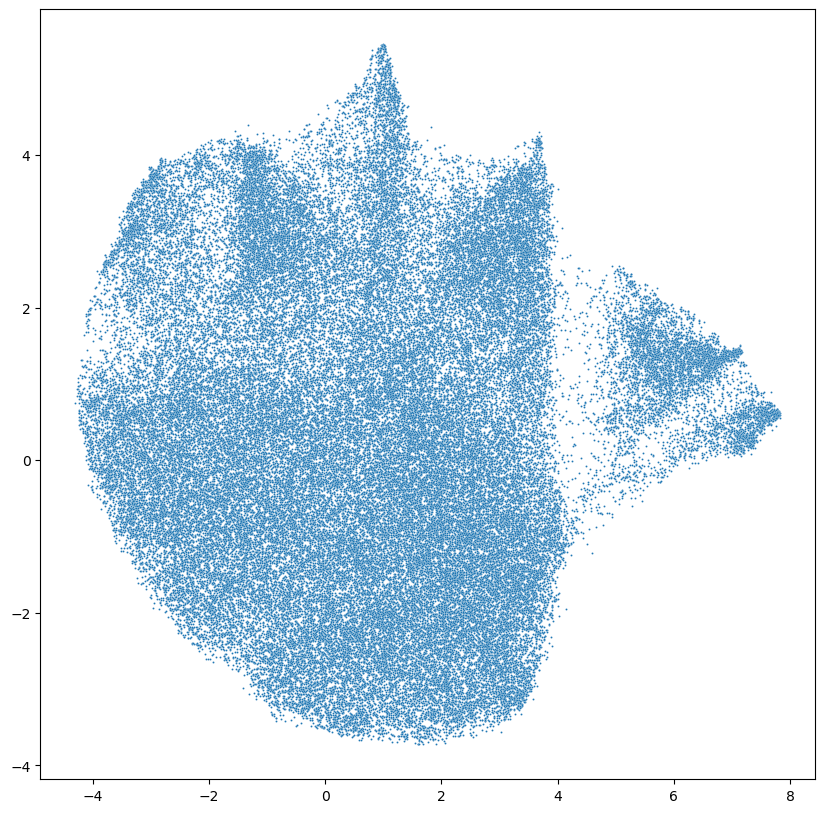

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(x=umap_coord[:, 0], y=umap_coord[:, 1], s=2, alpha=1)
plt.show()

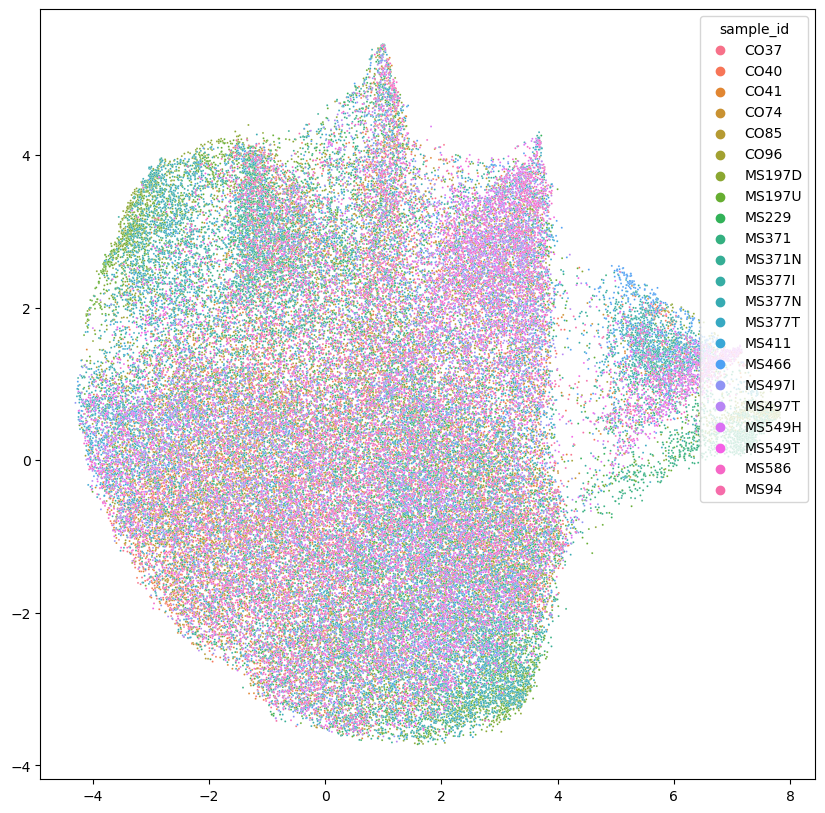

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(x=umap_coord[:, 0], y=umap_coord[:, 1], hue=meta_df.loc[model.get_cells().cell].sample_id, s=2, alpha=1)
plt.show()

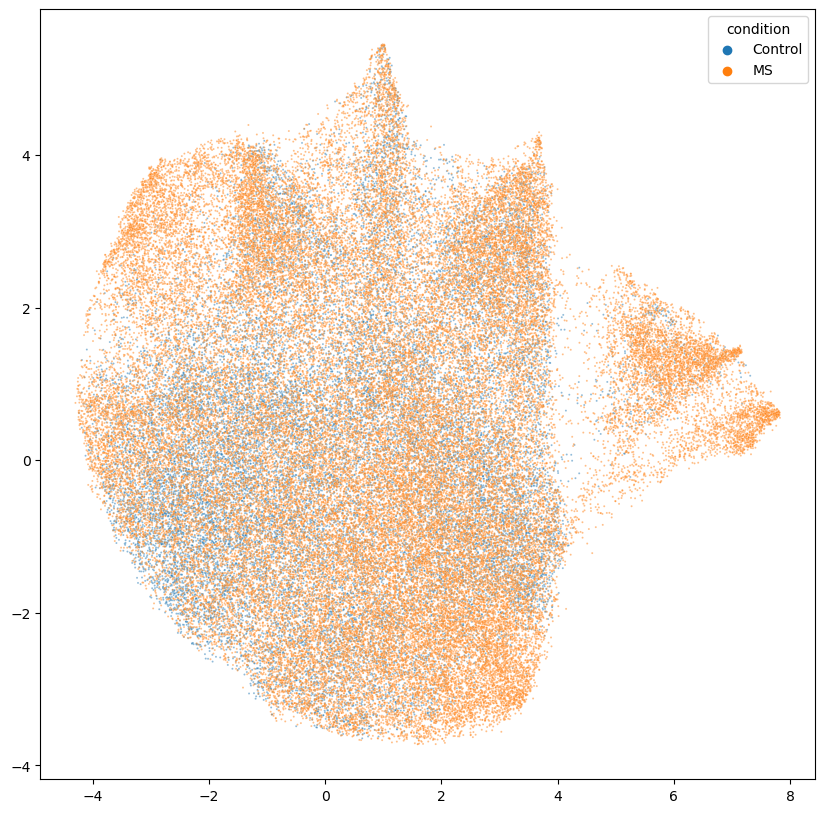

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(x=umap_coord[:, 0], y=umap_coord[:, 1], hue=meta_df.loc[model.get_cells().cell].condition, s=2, alpha=0.5)
plt.show()

In [79]:
model.get_factors().shape

(84258, 9)

In [80]:
model.get_r2()

,Factor,View,Group,R2
0,Factor1,abunds_all,CO37,27.637519
1,Factor1,hallmark_estimates,CO37,23.692943
2,Factor2,abunds_all,CO37,49.101884
3,Factor2,hallmark_estimates,CO37,7.377959
4,Factor3,abunds_all,CO37,-2.625136
...,...,...,...,...
13,Factor7,hallmark_estimates,MS94,1.319391
14,Factor8,abunds_all,MS94,-0.196396
15,Factor8,hallmark_estimates,MS94,1.533393
16,Factor9,abunds_all,MS94,-1.175024


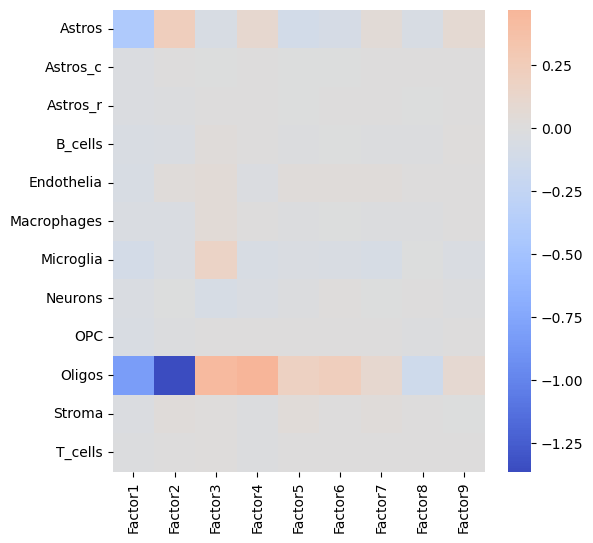

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.heatmap(model.get_weights(df=True).loc[obsm_features["abunds_all"], :], ax=ax, cmap="coolwarm", center=0)
plt.show()

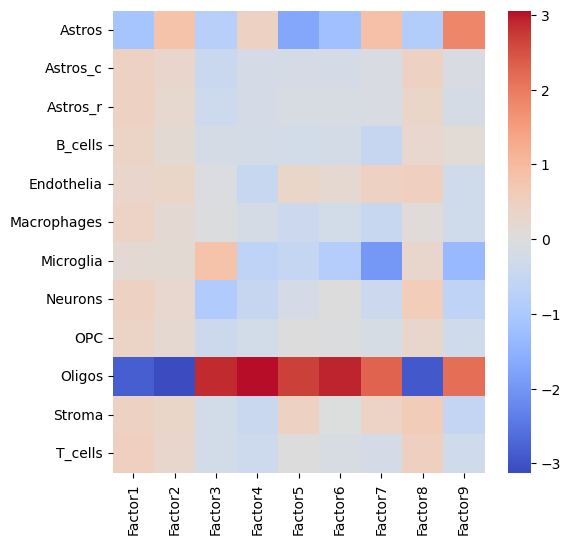

In [106]:
# same heatmap as above but standardize each column (subtract mean and divide by std)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
df = model.get_weights(df=True).loc[obsm_features["abunds_all"], :]
df = df.apply(lambda x: (x - x.mean()) / x.std(), axis=0)
sns.heatmap(df, ax=ax, cmap="coolwarm", center=0)
plt.show()

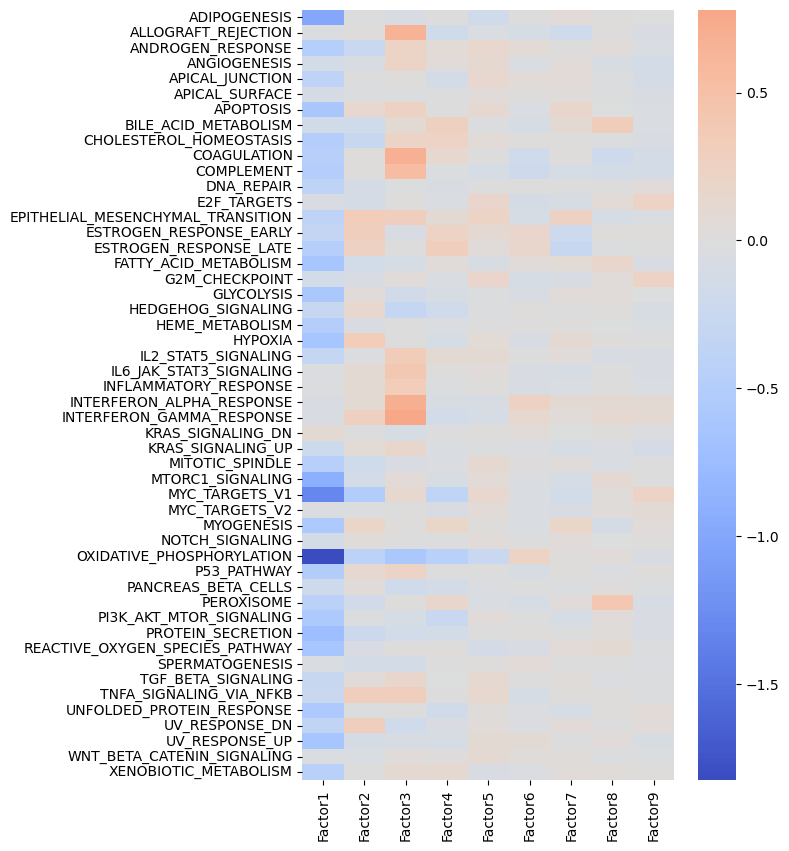

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(6, 10))
sns.heatmap(model.get_weights(df=True).loc[obsm_features["hallmark_estimates"], :], ax=ax, cmap="coolwarm", center=0)
plt.show()

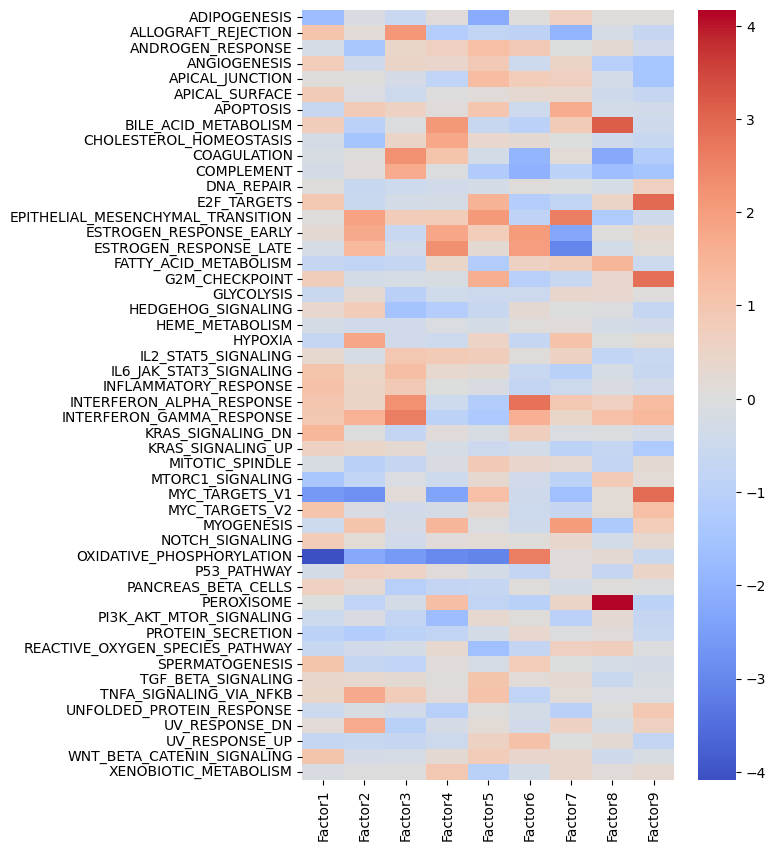

In [111]:
# same heatmap as above but standardize each column (subtract mean and divide by std)
fig, ax = plt.subplots(1, 1, figsize=(6, 10))
df = model.get_weights(df=True).loc[obsm_features["hallmark_estimates"], :]
df = df.apply(lambda x: (x - x.mean()) / x.std(), axis=0)
sns.heatmap(df, ax=ax, cmap="coolwarm", center=0)
plt.show()

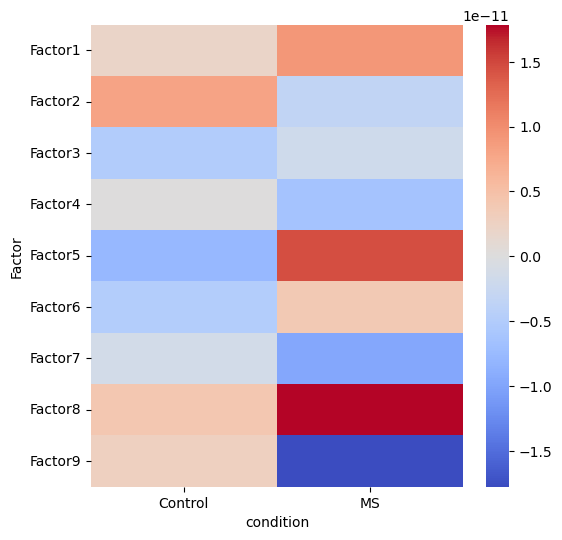

In [144]:
df = model.get_factors(df=True)
df["sample_id"] = meta_df.loc[model.get_cells().cell, "sample_id"].values
df["condition"] = meta_df.loc[model.get_cells().cell, "condition"].values
df["lesion_type"] = meta_df.loc[model.get_cells().cell, "lesion_type"].values
# pivot longer with all columns that start with "Factor"
df = df.reset_index().melt(id_vars=["index", "sample_id", "condition", "lesion_type"], var_name="Factor", value_name="value")

plot_df = df.groupby(["condition", "Factor"]).value.sum().to_frame().reset_index().pivot(index="Factor", columns="condition", values="value")
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.heatmap(plot_df, ax=ax, cmap="cool54warm", center=0)
plt.show()